# Simple Regression Models Analysis

In [1]:
import pandas as pd
import numpy as np
from pandas import Timestamp
import numpy
from scipy.stats import shapiro
from statsmodels.genmod.generalized_estimating_equations import GEE
import statsmodels.api as sm
from importlib import reload
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

In [2]:
sys.path.insert(0, '../code/')

/Users/dadler/miniforge3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import util
import regression_cv

### Open Data

In [4]:
crosscheck = pd.read_csv('../data/crosscheck_daily_data_cleaned_w_sameday.csv', index_col=0)

In [5]:
studentlife = pd.read_csv('../data/studentlife_daily_data_cleaned_w_sameday_08282021.csv')

## Prep for models

### Get features

In [6]:
# EMA cols
ema_cols_crosscheck = [i for i in crosscheck.columns if 'ema' in i]
ema_cols_studentlife = [i for i in studentlife.columns if 'ema' in i]

In [7]:
# Behavior cols
behavior_cols_crosscheck = [
    i for i in crosscheck.columns if i not in ['study_id', 'eureka_id', 'date'] + ema_cols_crosscheck
]

behavior_cols_studentlife = [
    i for i in studentlife.columns if i not in ['study_id', 'eureka_id', 'day'] + ema_cols_studentlife
]

behavior_cols = list(set(behavior_cols_crosscheck) & set(behavior_cols_studentlife))
behavior_cols.sort()

In [8]:
features = behavior_cols[:]

### Clean for model training

In [9]:
crosscheck_temp = crosscheck.copy()
crosscheck_temp[behavior_cols] = crosscheck_temp[behavior_cols].fillna(0) # Not using the columns with NAs. All 
                                                                          # ambient audio/light

features = [f for f in features if len(crosscheck_temp[f].unique()) > 1]

#### Transform StudentLife EMA to look like CrossCheck

In [10]:
studentlife_temp = studentlife[['study_id', 'day'] + 
    behavior_cols + ['ema_Stress_level', 'ema_Sleep_rate']
].reset_index(drop=True).copy() # TEMP FILL

# Fill NA
non_sleep_loc_cols = [i for i in behavior_cols if ('loc' not in i) and ('sleep' not in i)]
studentlife_temp[non_sleep_loc_cols] = studentlife_temp[non_sleep_loc_cols].fillna(0)

# Fill sleep with average value for that individual
for s in studentlife_temp.study_id.unique():
    temp = studentlife_temp.loc[studentlife_temp.study_id == s, :]
    duration_mean = temp['sleep_duration'].mean()
    start_mean = temp['sleep_start'].mean()
    end_mean = temp['sleep_end'].mean()
    ind = (studentlife_temp.study_id == s) & pd.isnull(studentlife_temp['sleep_duration'])
    studentlife_temp.loc[ind, 'sleep_duration'] = duration_mean
    studentlife_temp.loc[ind, 'sleep_start'] = start_mean
    studentlife_temp.loc[ind, 'sleep_end'] = end_mean

# Drop days without location (14 total) and days still w/o sleep (all IDs with no sleep info)
studentlife_temp = studentlife_temp.dropna(subset=behavior_cols).reset_index()

In [11]:
# Need to map all of them from 0-3

# Stress [1]A little stressed, [2]Definitely stressed, [3]Stressed out, [4]Feeling good, [5]Feeling great, 
studentlife_temp['ema_STRESSED'] = studentlife_temp['ema_Stress_level'].map({
    5:0, 4:0, 1:1, 2:2, 3:3
})
# Map from 0 - 3
minimum = studentlife_temp['ema_STRESSED'].min()
maximum = studentlife_temp['ema_STRESSED'].max()
studentlife_temp['ema_STRESSED'] =  3 * (studentlife_temp['ema_STRESSED'] - minimum) / (maximum - minimum)

# Sleeping [1]Very good, [2]Fairly good, [3]Fairly bad, [4]Very bad, 
# Map from 0 - 3
studentlife_temp['ema_SLEEPING'] = 4 - studentlife_temp['ema_Sleep_rate'].copy().round()

In [12]:
targets = ['ema_SLEEPING', 'ema_STRESSED']
studentlife_temp['data'] = 'sl'
crosscheck_temp['data']= 'cc'

In [13]:
crosscheck_temp['day'] = pd.to_datetime(crosscheck_temp['date']).dt.tz_localize('US/Eastern')

In [14]:
# Make study IDs dataset specific
crosscheck_temp['study_id'] = 'cc' + crosscheck_temp['study_id'].astype(str)
studentlife_temp['study_id'] = 'sl' + studentlife_temp['study_id'].astype(str)

### Base models CV

In [15]:
import warnings
warnings.filterwarnings("ignore")

## LOSO entire population

In [17]:
loso_res_df = pd.read_csv('../res/loso_res_df_all_v10_10182021.csv.gz')

In [18]:
y_true = []
y_pred = []
y_mean = []
mae_list = []
days_list = []
study_id = []
target = []
model_type = []
params = []
data = []
smote_list = []
neighbors_list = []

for ind in loso_res_df.index:
    s = loso_res_df.loc[ind, 'fold']
    t = loso_res_df.loc[ind, 'target']
    days_list += pd.to_datetime(eval(loso_res_df.loc[ind, 'day']))
    y_true += eval(loso_res_df.loc[ind, 'y_true'])
    y_pred += eval(loso_res_df.loc[ind, 'y_pred'])
    y_mean += eval(loso_res_df.loc[ind, 'y_mean'])
    study_id += [loso_res_df.loc[ind, 'fold']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    mae_list += [loso_res_df.loc[ind, 'mae']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    smote_list += [loso_res_df.loc[ind, 'smote']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    target += [loso_res_df.loc[ind, 'target']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    model_type += [loso_res_df.loc[ind, 'model_type']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    params += [loso_res_df.loc[ind, 'params']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    data += [loso_res_df.loc[ind, 'data']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    neighbors_list += [loso_res_df.loc[ind, 'neighbors']] \
        * len(eval(loso_res_df.loc[ind, 'y_true']))
    
df_overall_err = pd.DataFrame({
    'study_id': study_id,
    'day': days_list,
    'mae': mae_list,
    'smote': smote_list,
    'neighbors': neighbors_list,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_mean': y_mean,
    'target': target,
    'model_type': model_type,
    'params': params,
    'train_data': data
})

df_overall_err['day'] = pd.to_datetime(df_overall_err['day'], utc=True)

df_overall_err.loc[df_overall_err.y_pred >= 3, 'y_pred'] = 3
df_overall_err.loc[df_overall_err.y_pred <= 0, 'y_pred'] = 0

df_overall_err['dataset'] = [i[0:2] for i in df_overall_err.study_id]

df_overall_err['ae'] = np.abs(df_overall_err['y_true'] - df_overall_err['y_pred'])
df_overall_err['baseline_ae'] = np.abs(df_overall_err['y_true'] - df_overall_err['y_mean'])

df_overall_err['ae_round'] = np.abs(df_overall_err['y_true'] - np.round(df_overall_err['y_pred']))
df_overall_err['baseline_ae_round'] = np.abs(df_overall_err['y_true'] - np.round(df_overall_err['y_mean']))

df_overall_err.loc[pd.isnull(df_overall_err.neighbors), 'neighbors'] = 'None'

## Between training data results

#### Run tests to validate if better than means, each other

In [19]:
df_overall_pivot = pd.pivot_table(
    df_overall_err, index=['target', 'dataset', 'model_type', 'params', 'smote', 'neighbors', 'study_id', 'day'], 
    columns=['train_data'], values=['ae', 'baseline_ae']
).reset_index().fillna(0)
df_overall_pivot.columns = [
    i[0] if i[1] == '' else i[0] + '_' + i[1] for i in df_overall_pivot.columns]
df_overall_pivot['ae_single'] = df_overall_pivot['ae_cc'] + df_overall_pivot['ae_sl']
df_overall_pivot['baseline_ae'] = df_overall_pivot['baseline_ae_cc'] + df_overall_pivot['baseline_ae_sl']
df_overall_pivot['ae_diff'] = df_overall_pivot['ae_single'] - df_overall_pivot['ae_both']

In [20]:
df_overall_pivot_drop_dup = df_overall_pivot[
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset']
].drop_duplicates().reset_index(drop=True)
df_overall_pivot_drop_dup['baseline_single_res'] = None
df_overall_pivot_drop_dup['baseline_single_pval'] = None
df_overall_pivot_drop_dup['baseline_single_shap_pval'] = None
df_overall_pivot_drop_dup['baseline_both_res'] = None
df_overall_pivot_drop_dup['baseline_both_pval'] = None
df_overall_pivot_drop_dup['baseline_both_shap_pval'] = None
df_overall_pivot_drop_dup['res'] = None
df_overall_pivot_drop_dup['pval'] = None
df_overall_pivot_drop_dup['shap_pval'] = None
df_overall_pivot_drop_dup['reverse_res'] = None
df_overall_pivot_drop_dup['reverse_pval'] = None
df_overall_pivot_drop_dup['reverse_shap_pval'] = None

In [21]:
df_overall_pivot_drop_dup.groupby(['target', 'dataset'])['model_type'].count()

target        dataset
ema_SLEEPING  cc         432
              sl         432
ema_STRESSED  cc         432
              sl         432
Name: model_type, dtype: int64

In [22]:
# Validate better than baseline
total = df_overall_pivot_drop_dup.shape[0]

for ind in df_overall_pivot_drop_dup.index.values:
    temp = pd.merge(
        left=df_overall_pivot_drop_dup.loc[[ind], :],
        right=df_overall_pivot,
        on=['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset']
    )
    
    # Single
    p_shap = shapiro(temp['baseline_ae'] - temp['ae_single'])[1]
    res, p_test = util.rosner_test(temp, 'baseline_ae', 'ae_single', 'study_id')
    df_overall_pivot_drop_dup.loc[ind, 'baseline_single_res'] = res
    df_overall_pivot_drop_dup.loc[ind, 'baseline_single_pval'] = p_test
    df_overall_pivot_drop_dup.loc[ind, 'baseline_single_shap_pval'] = p_shap
    
    # Both
    p_shap = shapiro(temp['baseline_ae'] - temp['ae_both'])[1]
    res, p_test = util.rosner_test(temp, 'baseline_ae', 'ae_both', 'study_id')
    df_overall_pivot_drop_dup.loc[ind, 'baseline_both_res'] = res
    df_overall_pivot_drop_dup.loc[ind, 'baseline_both_pval'] = p_test
    df_overall_pivot_drop_dup.loc[ind, 'baseline_both_shap_pval'] = p_shap
    
    
    # Between both and single
    p_shap = shapiro(temp['ae_single'] - temp['ae_both'])[1]
    res, p_test = util.rosner_test(temp, 'ae_single', 'ae_both', 'study_id')
    df_overall_pivot_drop_dup.loc[ind, 'res'] = res
    df_overall_pivot_drop_dup.loc[ind, 'pval'] = p_test
    df_overall_pivot_drop_dup.loc[ind, 'shap_pval'] = p_shap
    
    # Reverse both and single
    p_shap = shapiro(temp['ae_both'] - temp['ae_single'])[1]
    res, p_test = util.rosner_test(temp, 'ae_both', 'ae_single', 'study_id')
    df_overall_pivot_drop_dup.loc[ind, 'reverse_res'] = res
    df_overall_pivot_drop_dup.loc[ind, 'reverse_pval'] = p_test
    df_overall_pivot_drop_dup.loc[ind, 'reverse_shap_pval'] = p_shap
    
    print(total - ind, 
          df_overall_pivot_drop_dup.loc[ind, 'pval'], df_overall_pivot_drop_dup.loc[ind, 'reverse_pval'])

1728 0.31590793431552344 0.6840920656844766
1727 0.3436925799044319 0.6563074200955681
1726 0.08888365648496566 0.9111163435150343
1725 0.0672999577128119 0.9327000422871881
1724 0.047555002382278194 0.9524449976177218
1723 0.5541117852559659 0.445888214744034
1722 0.8501417364388563 0.14985826356114373
1721 0.7657812514739848 0.23421874852601526
1720 0.70512950892672 0.29487049107328
1719 0.6220074825255926 0.37799251747440743
1718 0.9930244025539126 0.006975597446087403
1717 0.8457123266770028 0.15428767332299725
1716 0.5906520565806397 0.4093479434193603
1715 0.47790226073079545 0.5220977392692046
1714 0.16311106852671764 0.8368889314732824
1713 0.2741649682437892 0.7258350317562108
1712 0.2505436916835979 0.7494563083164021
1711 0.741409308197925 0.25859069180207495
1710 0.8344012262642353 0.1655987737357647
1709 0.800608842598006 0.19939115740199398
1708 0.7537832258669322 0.24621677413306775
1707 0.6905488608660136 0.30945113913398636
1706 0.9728622717820852 0.02713772821791488
1

KeyboardInterrupt: 

In [ ]:
# df_overall_pivot_drop_dup.to_csv('../res/df_overall_pivot_drop_dup_sig_v10_10192021.csv', index=False)

In [23]:
df_overall_pivot_drop_dup = pd.read_csv('../res/df_overall_pivot_drop_dup_sig_v10_10192021.csv')

In [24]:
df_overall_pivot_drop_dup['baseline_ae_single_sig'] = df_overall_pivot_drop_dup.baseline_single_pval < .05
df_overall_pivot_drop_dup['baseline_ae_both_sig'] = df_overall_pivot_drop_dup.baseline_both_pval < .05
df_overall_pivot_drop_dup['single_sig'] = df_overall_pivot_drop_dup.reverse_pval < .05
df_overall_pivot_drop_dup['both_sig'] = df_overall_pivot_drop_dup.pval < .05
df_overall_pivot_drop_dup['both_and'] = \
    df_overall_pivot_drop_dup.baseline_ae_both_sig & df_overall_pivot_drop_dup.both_sig
df_overall_pivot_drop_dup['single_and'] = \
    df_overall_pivot_drop_dup.baseline_ae_single_sig & df_overall_pivot_drop_dup.single_sig

In [28]:
df_overall_pivot_drop_dup.shape[0] / 4

432.0

In [29]:
df_overall_pivot_drop_dup.groupby(['target', 'dataset'])[[
    'both_sig', 'single_sig',  'baseline_ae_both_sig', 'baseline_ae_single_sig', 'both_and', 'single_and',
]].sum()

both_sig  single_sig  baseline_ae_both_sig  \
target       dataset                                               
ema_SLEEPING cc             67          24                    19   
             sl             35          19                    46   
ema_STRESSED cc             86          28                    21   
             sl             16           9                     4   

                      baseline_ae_single_sig  both_and  single_and  
target       dataset                                                
ema_SLEEPING cc                           18         2           0  
             sl                           44         1           0  
ema_STRESSED cc                           18         0           0  
             sl                            7         0           0

In [30]:
df_overall_err_grouped_by_study_id = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data', 'study_id'], as_index=False
)['ae', 'baseline_ae'].mean()

df_overall_err_grouped_by_model = df_overall_err_grouped_by_study_id.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data'], as_index=False
)['ae', 'baseline_ae'].mean()

In [31]:
df_overall_err_grouped_by_study_id_pivot = pd.pivot_table(
    df_overall_err_grouped_by_study_id,
    index=['target', 'model_type', 'smote', 'neighbors', 'params', 'dataset', 'study_id'],
    columns=['train_data'],
    values=['ae', 'baseline_ae']
).reset_index().fillna(0)
df_overall_err_grouped_by_study_id_pivot.columns = [
    i[0] if i[1] == '' else i[0] + '_' + i[1] for i in df_overall_err_grouped_by_study_id_pivot.columns.values
]
df_overall_err_grouped_by_study_id_pivot['ae_single'] = \
    df_overall_err_grouped_by_study_id_pivot['ae_cc'] + df_overall_err_grouped_by_study_id_pivot['ae_sl']

df_overall_err_grouped_by_study_id_pivot['baseline_ae_single'] = \
    df_overall_err_grouped_by_study_id_pivot['baseline_ae_cc'] + \
    df_overall_err_grouped_by_study_id_pivot['baseline_ae_sl']

df_overall_err_grouped_by_study_id_pivot.drop(
    ['ae_cc', 'ae_sl', 'baseline_ae_cc', 'baseline_ae_sl'], axis=1, inplace=True)


df_overall_err_grouped_by_study_id_pivot['mae_diff'] = \
    df_overall_err_grouped_by_study_id_pivot['ae_single'] - df_overall_err_grouped_by_study_id_pivot['ae_both']

In [32]:
df_overall_err_grouped_by_model_pivot = pd.pivot_table(
    df_overall_err_grouped_by_model,
    index=['target', 'model_type', 'smote', 'neighbors', 'params', 'dataset'],
    columns=['train_data'],
    values=['ae', 'baseline_ae']
).reset_index().fillna(0)
df_overall_err_grouped_by_model_pivot.columns = [
    i[0] if i[1] == '' else i[0] + '_' + i[1] for i in df_overall_err_grouped_by_model_pivot.columns.values
]
df_overall_err_grouped_by_model_pivot['ae_single'] = \
    df_overall_err_grouped_by_model_pivot['ae_cc'] + df_overall_err_grouped_by_model_pivot['ae_sl']

df_overall_err_grouped_by_model_pivot['baseline_ae_single'] = \
    df_overall_err_grouped_by_model_pivot['baseline_ae_cc'] + \
    df_overall_err_grouped_by_model_pivot['baseline_ae_sl']

df_overall_err_grouped_by_model_pivot.drop(
    ['ae_cc', 'ae_sl', 'baseline_ae_cc', 'baseline_ae_sl'], axis=1, inplace=True)


df_overall_err_grouped_by_model_pivot['mae_diff'] = \
    df_overall_err_grouped_by_model_pivot['ae_single'] - df_overall_err_grouped_by_model_pivot['ae_both']

In [33]:
df_overall_err_grouped_by_model_pivot_test = df_overall_err_grouped_by_model_pivot.groupby([
    'target', 'dataset'
], as_index=False).apply(
    util.grouped_paired_test, col1='ae_single', col2='ae_both').sort_values(
    by=['target', 'dataset']).reset_index(drop=True)


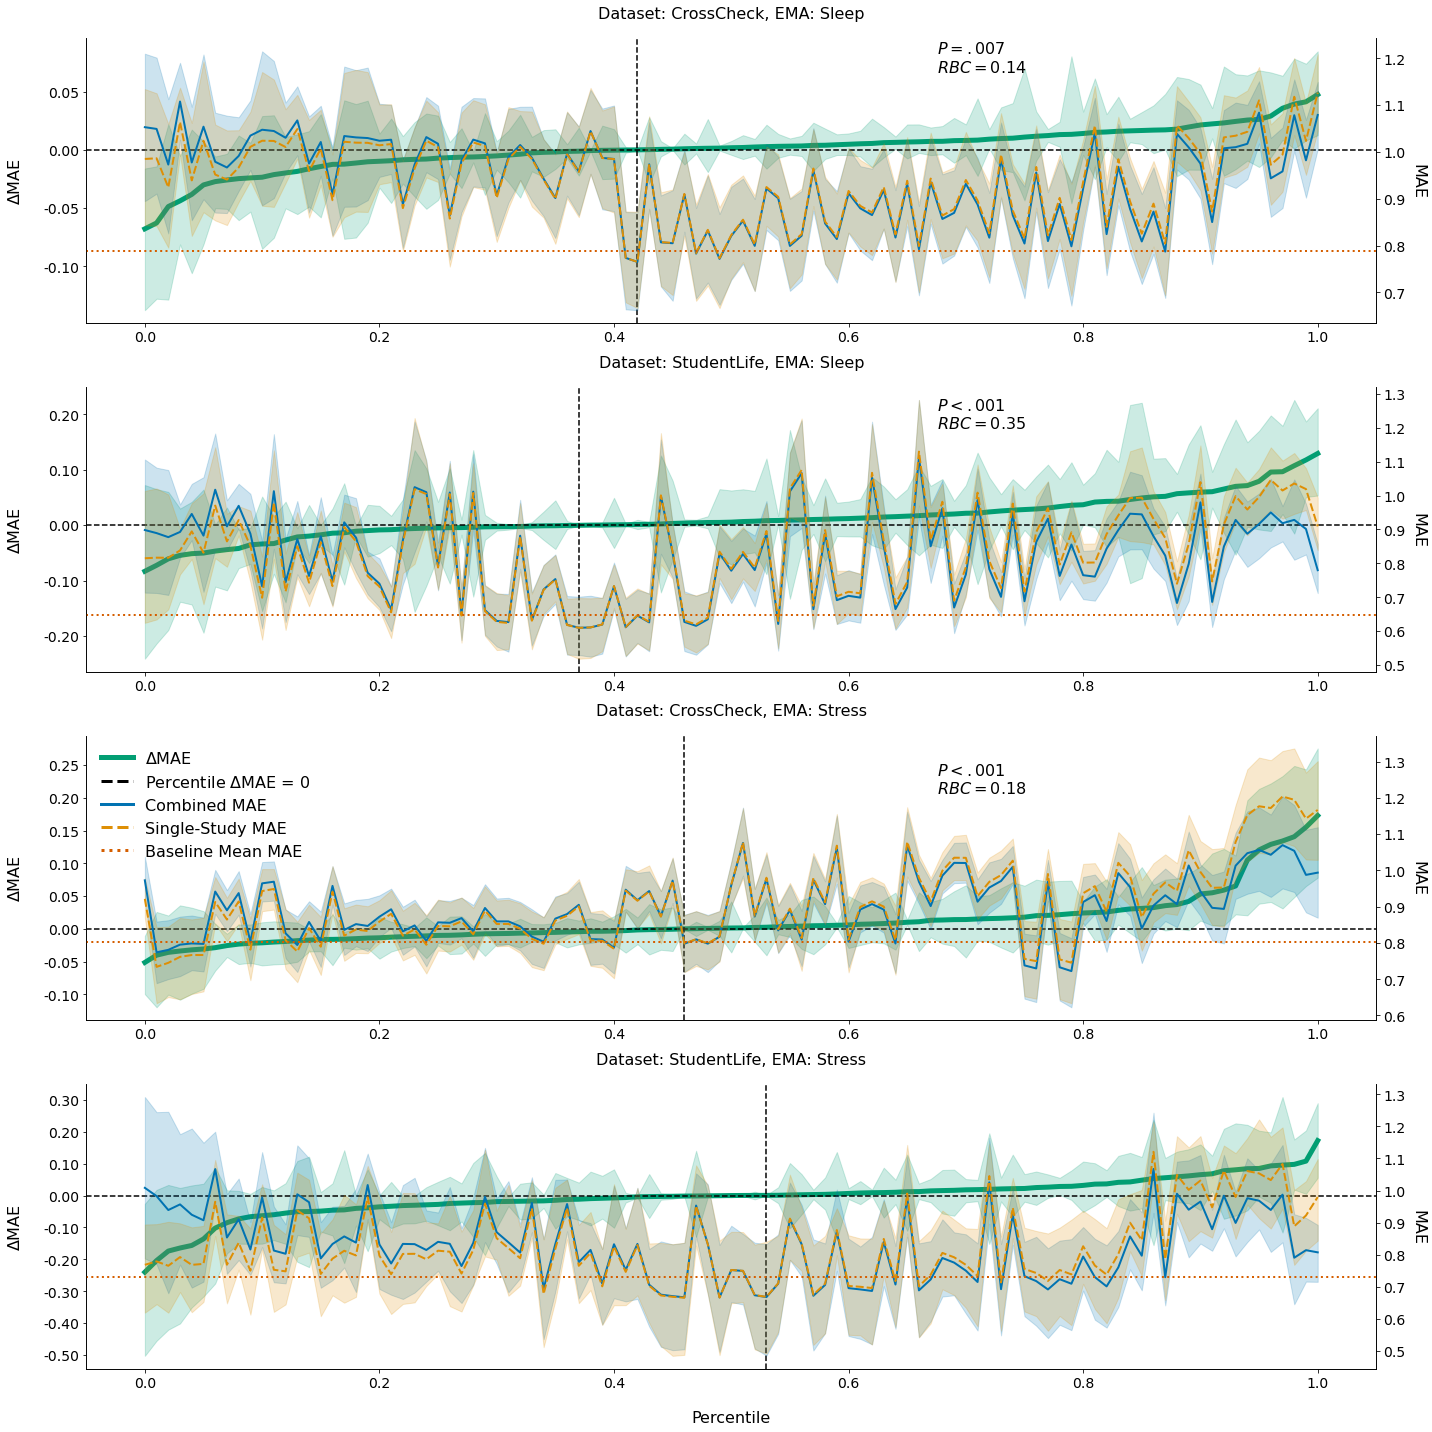

In [34]:
# In cases where differ by .01, graph
plt.figure(figsize=(20, 20))
curr = 1

param_cols = ['target', 'model_type', 'smote', 'neighbors', 'params', 'dataset']

percentiles = np.arange(0.0, 1.01, 0.01)

palette = sns.color_palette("colorblind", n_colors=4)
palette2 = sns.color_palette("cubehelix", n_colors=2)

target_map = {'ema_SLEEPING': 'EMA: Sleep', 'ema_STRESSED': 'EMA: Stress'}
dataset_map = {'cc': 'CrossCheck', 'sl': 'StudentLife'}

for t in df_overall_err_grouped_by_model_pivot.target.unique():
    for d in df_overall_err_grouped_by_model_pivot.dataset.unique():
        temp = df_overall_err_grouped_by_model_pivot.loc[
            (df_overall_err_grouped_by_model_pivot.target == t) &
            (df_overall_err_grouped_by_model_pivot.dataset == d), :].copy().sort_values(by='dataset')
        
        # Get num_ids
        num_ids = df_overall_err_grouped_by_study_id.loc[
            (df_overall_err_grouped_by_study_id.target == t) &
            (df_overall_err_grouped_by_study_id.dataset == d), 'study_id'
        ].nunique()
        
        # Get quantiles
        mae_diff = []
        single_mae = []
        both_mae = []
        baseline_single_mae = []
        baseline_both_mae = []
        percentiles_list = []
        for q in percentiles:
            params = temp.loc[temp.mae_diff == temp.mae_diff.quantile(q=q, interpolation='nearest'), param_cols
                             ].iloc[[0], :]
            temp2 = pd.merge(left=params, right=df_overall_err_grouped_by_study_id_pivot)
            
            single_mae += list(temp2['ae_single'])
            both_mae += list(temp2['ae_both'])
            baseline_single_mae += list(temp2['baseline_ae_single'])
            baseline_both_mae += list(temp2['baseline_ae_both'])
            mae_diff += list(temp2['mae_diff'])
            percentiles_list += [q] * num_ids

        ax = plt.subplot(4, 1, curr)

        ax = sns.lineplot(x=percentiles_list, y=mae_diff, color=palette[2], lw=5, ax=ax)
        plt.title('Dataset: ' + dataset_map[d] + ', ' + target_map[t], size=16, pad=20)
        
        if curr < 4:
            plt.xlabel('')
        else:
            plt.xlabel('Percentile', labelpad=20, size=16)


        plt.ylabel('$\Delta$MAE', labelpad=20, size=16)

        plt.xticks(size=14)
        plt.yticks(size=14)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        mae_dff_df = pd.DataFrame({
            'mae_diff': np.abs(mae_diff),
            'percentiles': percentiles_list
        })
        
        mae_dff_df_grouped = mae_dff_df.groupby(['percentiles'])['mae_diff'].mean()

        plt.axhline(y=0, color='k', ls='dashed')
        plt.axvline(x=mae_dff_df_grouped.idxmin(), color='k', ls='dashed')

        # Add marks
        temp_test = df_overall_err_grouped_by_model_pivot_test.loc[
            (df_overall_err_grouped_by_model_pivot_test.target == t) &
            (df_overall_err_grouped_by_model_pivot_test.dataset == d), :
        ].copy()
        max_val = ax.get_ylim()[1]
        temp_test.index = temp_test.dataset
        if temp_test.loc[d, 'test'] == 'W':
            effect = '\n$RBC=' + str(temp_test.loc[d, 'effect'].round(2)) + '$'
        else:
            effect = '\n$Cohen-d=' + str(temp_test.loc[d, 'effect'].round(2)) + '$'
        if temp_test.loc[d, 'pval'] < .001:
            plt.text(s='$P<.001$' + effect, x=0.675, y=max_val * 0.7, size=16)
        elif temp_test.loc[d, 'pval'] < .05:
            plt.text(
                s='$P=' + str(temp_test.loc[d, 'pval'].round(3))[1:] + '$' + effect, 
                x=0.675, y=max_val * 0.7, size=16)
        elif temp_test.loc[d, 'pval'] < .1:
            plt.text(s='$P<.1$' + effect, x=0.675, y=max_val * 0.7, size=16)
        
        ax2 = ax.twinx()
        
        quantile_df = pd.DataFrame({
            'percentile': percentiles_list *2,
            'MAE': both_mae + single_mae ,
            'Training Data': ['Combined'] * len(both_mae) + [dataset_map[d]] * len(single_mae),
            'style': ['-'] * len(both_mae) + ['--'] * len(single_mae),
        })
        ax2 = sns.lineplot(x=quantile_df['percentile'], y=quantile_df['MAE'], hue=quantile_df['Training Data'],
                      palette=palette[:2], ax=ax2, lw=2, style=quantile_df['style'], alpha=1)
        plt.axhline(y=np.mean(baseline_single_mae), color=palette[-1], ls=':', alpha=1, lw=2)
        
        plt.xlabel('')
        
        
        if curr == 3:
            custom_lines = [
                Line2D([0], [0], color=palette[2], lw=5, ls='-'),
                Line2D([0], [0], color='k', lw=3, ls='dashed', alpha=1),
                Line2D([0], [0], color=palette[0], lw=3, ls='-', alpha=1),
                Line2D([0], [0], color=palette[1], lw=3, ls='--', alpha=1),
                Line2D([0], [0], color=palette[-1], lw=3, ls=':', alpha=1),
            ]
            ax2.legend(custom_lines, 
                       ['$\Delta$MAE', 'Percentile $\Delta$MAE = 0',
                        'Combined MAE', 'Single-Study MAE', 'Baseline Mean MAE'], 
                       prop={'size': 16}, frameon=False)
        else:
            ax2.get_legend().remove()
        
        plt.xticks(size=14)
        plt.yticks(size=14)
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.ylabel('MAE', labelpad=20, size=16, rotation=-90)
        curr += 1
    
        
sns.despine(right=False)
plt.tight_layout()

## Proxy-A Dist

### Proxy-A Dist Overall

In [37]:
target_list = []
study_id_list = []
train_data_list = []
smote_list = []
neighbors_list = []
proxy_a_dist_list = []
emd_list = []

for target in targets:
    for smote in [False, True]:
        for neighbors in [None, 5, 10, 50, 100, 500]:
            for train_data in ['cc', 'sl', 'both']:
                if train_data == 'sl':
                    data = studentlife_temp.copy()
                elif train_data == 'cc':
                    data = crosscheck_temp.copy()
                else:
                    data = pd.concat(
                        [crosscheck_temp, studentlife_temp], axis=0).reset_index(drop=True) 
                for t, v in zip(*regression_cv.get_loso_cv_data(
                    data=data, features=features, target=target
                )):

                    train_norm, val_norm = regression_cv.scale_data(
                        train=t, val=v, features=features, 
                        target=target, neighbors=neighbors, smote=smote
                    )
                    # Get proxy a distance
                    proxy_a_dist = util.proxy_a_distance(
                        d1=train_norm, d2=val_norm, features=features)
                    
                    # Get EMD
                    emd = util.calculate_emd(d1=train_norm[features], d2=val_norm[features], center=False)

                    target_list.append(target)
                    study_id_list.append(v.study_id.unique()[0])
                    train_data_list.append(train_data)
                    smote_list.append(smote)
                    neighbors_list.append(neighbors)
                    proxy_a_dist_list.append(proxy_a_dist)
                    emd_list.append(emd)

                    print(
                        target, train_data, v.study_id.unique()[0], smote, 
                        neighbors, proxy_a_dist, emd
                    )

ema_SLEEPING cc cc2 False None 1.8411370600360302 4.784412303622354
ema_SLEEPING cc cc3 False None 1.8440378195743767 6.484737060201501
ema_SLEEPING cc cc6 False None 1.8647451596829125 5.180564223419314


KeyboardInterrupt: 

In [ ]:
dist_df = pd.DataFrame({
    'target': target_list,
    'study_id': study_id_list,
    'train_data': train_data_list,
    'smote': smote_list,
    'neighbors': neighbors_list,
    'proxy_a_dist': proxy_a_dist_list,
    'emd': emd_list
})

In [ ]:
# dist_df.to_csv('../res/dist_v10_10192021.csv', index=False)

In [38]:
dist_df = pd.read_csv('../res/dist_v10_10192021.csv')

In [39]:
dist_df.loc[pd.isnull(dist_df.neighbors), 'neighbors'] = 'None'

In [40]:
df_overall_err_dist = df_overall_err.groupby(
    ['target', 'smote', 'neighbors', 'study_id', 'dataset', 'train_data'], as_index=False)[['ae']].mean()

In [41]:
df_overall_err_dist = pd.merge(
    left=df_overall_err_dist,
    right=dist_df
)

#### Per Participant Proxy A Dist

In [43]:
df_overall_err_dist_pivot = pd.pivot_table(
    df_overall_err_dist,
    index=['target', 'smote', 'neighbors', 'dataset', 'study_id'],
    columns=['train_data'],
    values=['ae', 'proxy_a_dist']
).reset_index().fillna(0)
df_overall_err_dist_pivot.columns = [
    i[0] if i[1] == '' else i[0] + '_' + i[1] for i in df_overall_err_dist_pivot.columns
]
df_overall_err_dist_pivot['ae_single'] = df_overall_err_dist_pivot['ae_cc'] + df_overall_err_dist_pivot['ae_sl']
df_overall_err_dist_pivot['mae_diff'] = df_overall_err_dist_pivot['ae_single'] - df_overall_err_dist_pivot['ae_both']
df_overall_err_dist_pivot['proxy_a_dist_single'] = \
    df_overall_err_dist_pivot['proxy_a_dist_cc'] + df_overall_err_dist_pivot['proxy_a_dist_sl']
df_overall_err_dist_pivot['proxy_a_dist_diff'] = \
    df_overall_err_dist_pivot['proxy_a_dist_single'] - df_overall_err_dist_pivot['proxy_a_dist_both']

In [45]:
if 'neighbors_10.0' not in df_overall_err_dist_pivot.columns.values:
    df_overall_err_dist_pivot = pd.concat([
        df_overall_err_dist_pivot,
        pd.get_dummies(df_overall_err_dist_pivot[['target', 'neighbors', 'dataset']], drop_first=True)
    ], axis=1)
df_overall_err_dist_pivot['bias'] = 1

cols = ['proxy_a_dist_diff', 'target_ema_STRESSED',
       'bias']

gee = GEE(
    endog=df_overall_err_dist_pivot['mae_diff'],
    exog=df_overall_err_dist_pivot[cols],
    groups=df_overall_err_dist_pivot['study_id'],
    cov_struct=sm.cov_struct.Exchangeable()
)
gee_res = gee.fit()
gee_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    mae_diff   No. Observations:                 1512
Model:                                 GEE   No. clusters:                       66
Method:                        Generalized   Min. cluster size:                  12
                      Estimating Equations   Max. cluster size:                  24
Family:                           Gaussian   Mean cluster size:                22.9
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Fri, 29 Oct 2021   Scale:                           0.007
Covariance type:                    robust   Time:                         15:22:50
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
proxy_a_dist_diff       0.0703      0.024      2.900      0.004       0.023       0.118
target_ema_STRESSED     0.0053      0.007      0.715      0.475      -0.009       0.020
bias                    0.0040      0.003      1.158      0.247      -0.003       0.011
==============================================================================
Skew:                          0.5413   Kurtosis:                       5.3302
Centered skew:                 0.6464   Centered kurtosis:              4.6839
==============================================================================
"""

## Nearest Neighbor Analysis

In [46]:
df_overall_err_grouped = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data', 'study_id'], as_index=False
)['ae'].mean()

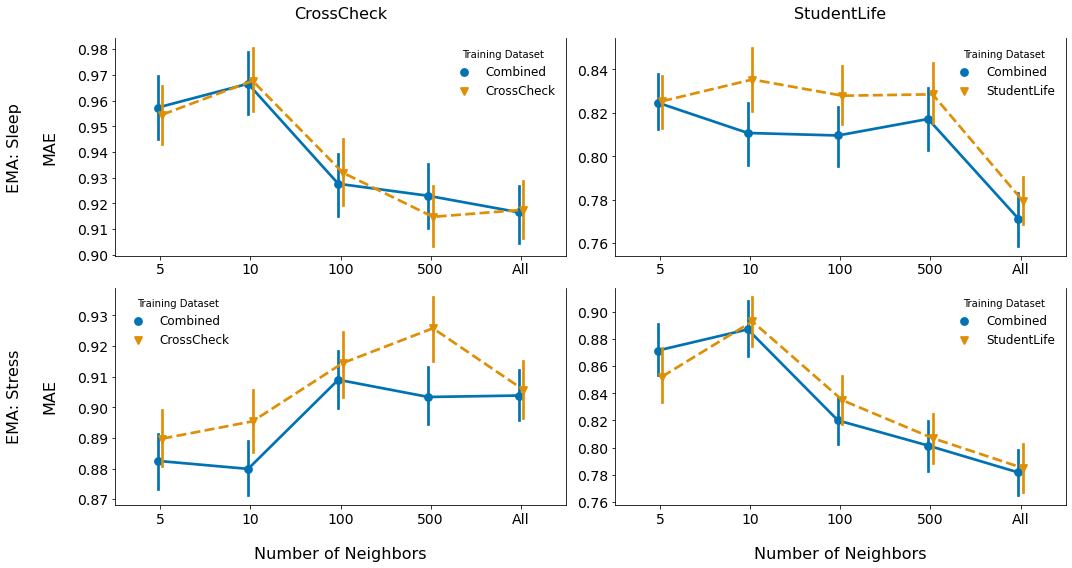

In [47]:
plt.figure(figsize=(15, 8))
curr = 1

palette = sns.color_palette("colorblind", n_colors=4)

target_map = {'ema_SLEEPING': 'EMA: Sleep', 'ema_STRESSED': 'EMA: Stress'}
dataset_map = {'cc': 'CrossCheck', 'sl': 'StudentLife'}

for t in df_overall_err_grouped.target.unique():
    for d in df_overall_err_grouped.dataset.unique():
        temp = df_overall_err_grouped.loc[(df_overall_err_grouped.target == t) & 
                                          (df_overall_err_grouped.dataset == d), :].copy()
        temp.loc[temp['neighbors'] == 'None', 'neighbors'] = 'All'
        temp['train_data'] = temp['train_data'].map({'sl': 'StudentLife', 'cc': 'CrossCheck', 'both': 'Combined'})
        temp = pd.merge(
            left=pd.DataFrame({'neighbors': [5, 10, 100, 500, 'All']}),
            right=temp
        )
        plt.subplot(2, 2, curr)
                
        ax = sns.pointplot(
            x=temp['neighbors'], y=temp['ae'], 
            hue=temp['train_data'], linestyles=["-", "--"], markers=['o', 'v'], palette=palette[:2],
            dodge=True, estimate='mean'
        )
        
        plt.legend(title='Training Dataset', prop={'size': 12}, frameon=False)
        
        if curr in [1, 2]:
            plt.title(dataset_map[d], size=16, pad=20)
            plt.xlabel('')
        else:
            plt.xlabel('Number of Neighbors', labelpad=20, size=16)
            
        if curr in [1, 3]:
            plt.ylabel(target_map[t] + '\n\nMAE', labelpad=20, size=16)
        else:
            plt.ylabel('')
            
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.xticks(size=14)
        plt.yticks(size=14)
        
        curr += 1
        
sns.despine(right=False)
plt.tight_layout()

## Smote effects

In [48]:
df_overall_err['y_pred_round'] = df_overall_err['y_pred'].round()

df_overall_err_var = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data', 'y_pred_round'
    ], as_index=False
)['day'].count().rename(columns={'day': 'value_counts'})

In [49]:
# Add class values
df_overall_err['y_pred_class'] = 0
df_overall_err['y_true_class'] = 0

df_overall_err.loc[
    (df_overall_err.target == 'ema_SLEEPING') & (df_overall_err.y_true <= 1), 'y_true_class'
] = 1
df_overall_err.loc[
    (df_overall_err.target == 'ema_STRESSED') & (df_overall_err.y_true >= 2), 'y_true_class'
] = 1

df_overall_err.loc[
    (df_overall_err.target == 'ema_SLEEPING') & (df_overall_err.y_pred_round <= 1), 'y_pred_class'
] = 1
df_overall_err.loc[
    (df_overall_err.target == 'ema_STRESSED') & (df_overall_err.y_pred_round >= 2), 'y_pred_class'
] = 1

In [50]:
df_overall_err_sensitivity = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data'], as_index=False
).apply(util.grouped_sensitivity, y_true='y_true_class', y_pred='y_pred_class').rename(columns={None: 'value'})

df_overall_err_ppv = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data'], as_index=False
).apply(util.grouped_ppv, y_true='y_true_class', y_pred='y_pred_class').rename(columns={None: 'value'})

df_overall_err_specificity = df_overall_err.groupby(
    ['target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data'], as_index=False
).apply(util.grouped_specificity, y_true='y_true_class', y_pred='y_pred_class').rename(columns={None: 'value'})

In [52]:
df_overall_err_sensitivity['metric'] = 'Sensitivity'
df_overall_err_ppv['metric'] = 'PPV'
df_overall_err_specificity['metric'] = 'Specificity'

df_overall_err_mae = df_overall_err_grouped.groupby([
    'target', 'model_type', 'params', 'smote', 'neighbors', 'dataset', 'train_data'
], as_index=False)['ae'].mean()
df_overall_err_mae['metric'] = 'MAE'
df_overall_err_mae.rename(columns={'ae': 'value'}, inplace=True)

df_overall_err_metrics = pd.concat([
    df_overall_err_sensitivity, df_overall_err_ppv, df_overall_err_specificity, #, df_overall_err_f1, 
    df_overall_err_mae
]).reset_index(drop=True)

In [53]:
# Quantify differences
df_overall_err_metrics_pivot = pd.pivot_table(
    data=df_overall_err_metrics,
    index=['target', 'model_type', 'params', 'neighbors', 'dataset', 'train_data', 'metric'],
    columns=['smote'],
    values=['value']
).reset_index()
df_overall_err_metrics_pivot.columns = [
    i[0] if i[1] == '' else str(i[0]) + '_' + str(i[1]) for i in df_overall_err_metrics_pivot.columns.values
]

df_overall_err_metrics_pivot_test = df_overall_err_metrics_pivot.groupby([
    'target', 'metric', 'dataset'
], as_index=False).apply(util.grouped_paired_test, col1='value_True', col2='value_False'
                        ).sort_values(
    by=['target', 'dataset', 'metric']
).reset_index(drop=True)

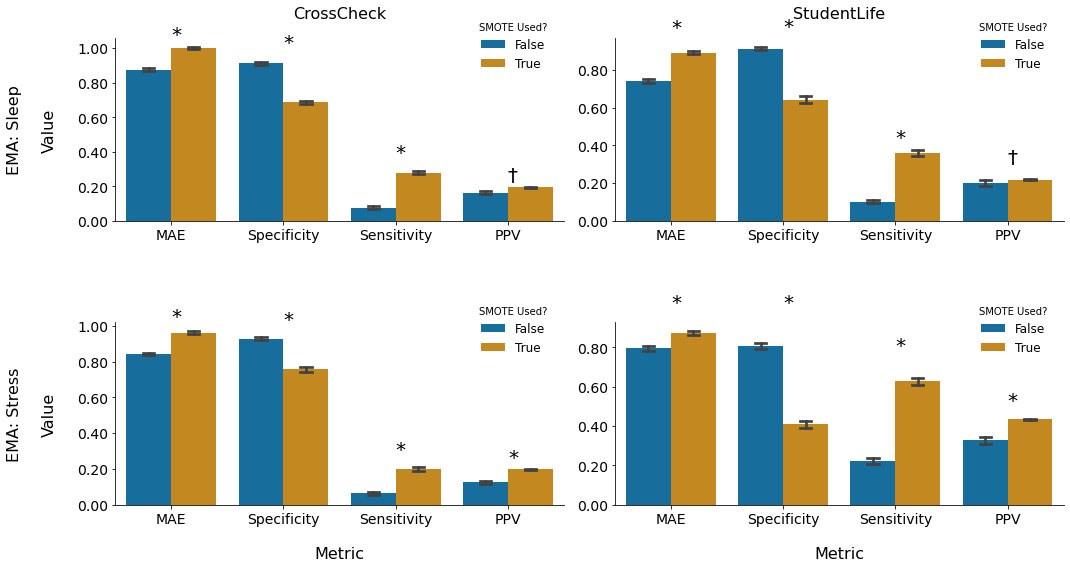

In [54]:
plt.figure(figsize=(15, 8))
curr = 1

palette = sns.color_palette("colorblind", n_colors=4)

target_map = {'ema_SLEEPING': 'EMA: Sleep', 'ema_STRESSED': 'EMA: Stress'}
dataset_map = {'cc': 'CrossCheck', 'sl': 'StudentLife'}

for t in df_overall_err_metrics.target.unique():
    for d in df_overall_err_metrics.dataset.unique():
        temp = df_overall_err_metrics.loc[(df_overall_err_metrics.target == t) & 
                                          (df_overall_err_metrics.dataset == d), :
                                         ].copy().sort_values(by=['metric']).reset_index(drop=True)
        temp['train_data'] = temp['train_data'].map({'sl': 'StudentLife', 'cc': 'CrossCheck', 'both': 'Combined'})
        
        temp = pd.merge(
            left=pd.DataFrame({'metric': ['MAE', 'Specificity', 'Sensitivity', 'PPV']}),
            right=temp
        )
        
        plt.subplot(2, 2, curr)
                
        ax = sns.barplot(
            x=temp['metric'], y=temp['value'], 
            hue=temp['smote'], palette=palette[:2],
            capsize=0.1
        )
        
        
        plt.legend(title='SMOTE Used?', prop={'size': 12}, frameon=False, loc=(0.8, 0.8))
        
        if curr in [1, 2]:
            plt.title(dataset_map[d], size=16, pad=20)
            plt.xlabel('')
        else:
            plt.xlabel('Metric', labelpad=20, size=16)
            
        if curr in [1, 3]:
            plt.ylabel(target_map[t] + '\n\nValue', labelpad=20, size=16)
        else:
            plt.ylabel('')
            
        plt.xticks(size=14)
        plt.yticks(size=14)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        # Add marks
        temp_pivot = df_overall_err_metrics_pivot_test.loc[
            (df_overall_err_metrics_pivot_test.target == t) & (df_overall_err_metrics_pivot_test.dataset == d), :
        ].copy()
        max_val = ax.get_ylim()[1]
        temp_pivot.index = temp_pivot.metric
        
        
        if (temp_pivot.loc['MAE', 'pval'] > .95) or (temp_pivot.loc['MAE', 'pval'] < .05):
            plt.text(s='*', x=0, y=temp.loc[temp.metric == 'MAE', 'value'].quantile(0.9), size=20)
        elif (temp_pivot.loc['MAE', 'pval'] > .9) or (temp_pivot.loc['MAE', 'pval'] < .1):
            plt.text(s='†', x=0, y=temp.loc[temp.metric == 'MAE', 'value'].quantile(0.9), size=20)
            
        if (temp_pivot.loc['Specificity', 'pval'] < .05) or (temp_pivot.loc['Specificity', 'pval'] > .95):
            plt.text(s='*', x=1, y=temp.loc[temp.metric == 'Specificity', 'value'].quantile(0.9), size=20)
        elif (temp_pivot.loc['Specificity', 'pval'] < .1) or (temp_pivot.loc['Specificity', 'pval'] > .9):
            plt.text(s='†', x=1, y=temp.loc[temp.metric == 'Specificity', 'value'].quantile(0.9), size=20)
            
        if (temp_pivot.loc['Sensitivity', 'pval'] < .05) or (temp_pivot.loc['Sensitivity', 'pval'] > .95):
            plt.text(s='*', x=2, y=temp.loc[temp.metric == 'Sensitivity', 'value'].quantile(0.9), size=20)
        elif (temp_pivot.loc['Sensitivity', 'pval'] < .1) or (temp_pivot.loc['Sensitivity', 'pval'] > .9):
            plt.text(s='†', x=2, y=temp.loc[temp.metric == 'Sensitivity', 'value'].quantile(0.9), size=20)
        
        if (temp_pivot.loc['PPV', 'pval'] < .05) or (temp_pivot.loc['PPV', 'pval'] > .95):
            plt.text(s='*', x=3, y=temp.loc[temp.metric == 'PPV', 'value'].quantile(0.9), size=20)
        elif (temp_pivot.loc['PPV', 'pval'] < .1) or (temp_pivot.loc['PPV', 'pval'] > .9):
            plt.text(s='†', x=3, y=temp.loc[temp.metric == 'PPV', 'value'].quantile(0.9), size=20)
              
        
        curr += 1
        
sns.despine()
plt.tight_layout(h_pad=5)